## QUBO problem with Grover Optimizer

In [3]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-09-17 05:10:40,817: Credentials are already in use. The existing account in the session will be replaced.


## Introduction

In this tutorial, we briefly introduce how to build optimization problems using Qiskit's optimization module.
Qiskit introduces the `QuadraticProgram` class to make a model of an optimization problem.
More precicely, it deals with quadratically constrained quadratic programs given as follows:

$$
\begin{align}
\text{minimize}\quad& x^\top Q_0 x + c^\top x\\
\text{subject to}\quad& A x \leq b\\
& x^\top Q_i x + a_i^\top x \leq r_i, \quad 1,\dots,i,\dots,q\\
& l_i \leq x_i \leq u_i, \quad 1,\dots,i,\dots,n,
\end{align}
$$

where the $Q_i$ are $n \times n$ matrices, $A$ is a $m \times n$ matrix , $x$, and $c$ are $n$-dimensional vectors, $b$ is an $m$-dimensional vector, and where $x$ can defined as binary, integer, or continuous variables.
In addition to "$\leq$" constraints 'QuadraticProgram' also supports "$\geq$" and "$=$".

Optimization problems in Qiskit's optimization module are represented with the `QuadraticProgram` class, which is generic and powerful representation for optimization problems. In general, optimization algorithms are defined for a certain formulation of a quadratic program and we need to convert our problem to the right type.

For instance, Qiskit provides several optimization algorithms that can handle `Quadratic Unconstrained Binary Optimization (QUBO) problems`. These are mapped to Ising Hamiltonians, for which Qiskit uses the `qiskit.aqua.operators` module, and then their ground state is approximated. For this optimization commonly known algorithms such as VQE or QAOA can be used as underlying routine. See the following tutorial about the [Minimum Eigen Optimizer](./3_minimum_eigen_optimizer.ipynb) for more detail. Note that also other algorithms exist that work differently, such as the `GroverOptimizer`.

To map a problem to the correct input format, the optimization module of Qiskit offers a variety of converters. In this tutorial we're providing an overview on this functionality. Currently, Qiskit contains the following converters.
- `InequalityToEquality`: converts inequality constraints into equality constraints with additional slack variables.
- `IntegerToBinary`: converts integer variables into binary variables and corresponding coefficients. 
- `LinearEqualityToPenalty`: convert equality constraints into additional terms of the object function.
- `QuadraticProgramToQubo`: a wrapper for `InequalityToEquality`, `IntegerToBinary`, and `LinearEqualityToPenalty` for convenience.

## Variational Quantum Eigensolver (VQE)
 Finding the solution to a QUBO is equivalent to finding the ground state of a corresponding Ising Hamiltonian, which is an important problem not only in optimization, but also in quantum chemistry and physics. For this translation, the binary variables taking values in $\{0, 1\}$ are replaced by spin variables taking values in $\{-1, +1\}$, which allows to replace the resulting spin variables by Pauli Z matrices, and thus, an Ising Hamiltonian. For more details on this mapping we refere to [1].

Qiskit provides automatic conversion from a suitable `QuadraticProgram` to an Ising Hamiltonian, which then allows to leverage all the `MinimumEigenSolver` such as
- `VQE`,
- `QAOA`, or
- `NumpyMinimumEigensolver` (classical exact method).


## Annealer

# Grover Optimizer

Grover Adaptive Search (GAS) has been explored as a possible solution for combinatorial optimization problems. The algorithm iteratively applies Grover Search to find the optimum value of an objective function, by using the best-known value from the previous run as a threshold. The adaptive oracle used in GAS recognizes all values above or below the current threshold (for max and min respectively), decreasing the size of the search space every iteration the threshold is updated, until an optimum is found.

## Grover Adaptive Search
Grover Search, the core element of GAS, needs three ingredients:

1. A state preparation operator $A$ to construct a superposition of all states in the search space.

2. An oracle operator $O$, that recognizes the states of interest and multiplies their amplitudes by -1.

3. The Grover diffusion operator $D$, that multiplies the amplitude of the $|0\rangle_n$ state by -1.

While implementations of GAS vary around the specific use case, the general framework still loosely follows the steps described below.

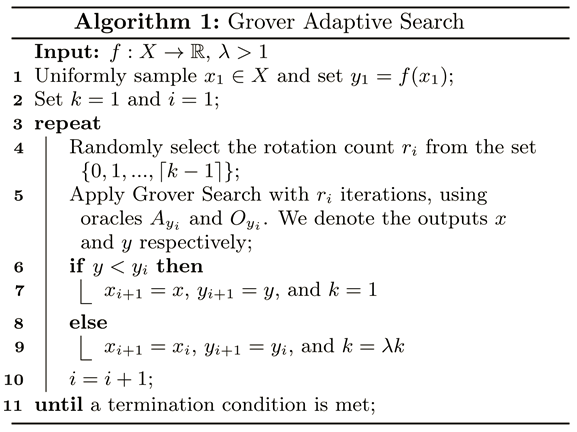

```GroverOptimizer``` uses ```QuadraticProgramToNegativeValueOracle``` to construct $A_y$ such that it prepares a $n$-qubit register to represent the equal superposition of all $|x\rangle_n$ and a $m$-qubit register to (approximately) represent the corresponding $|Q(x)-y\rangle_m$. Then, all states with $(Q(x) - y)$ negative should be flagged by $O_y$. Note that in the implementation discussed, the oracle operator is actually independent of $y$, but this is not a requirement. For clarity, we will refer to the oracle as $O$ when the oracle is independent of $y$.

Put formally, ```QuadraticProgramToNegativeValueOracle``` constructs an $A_y$ and $O$ such that:

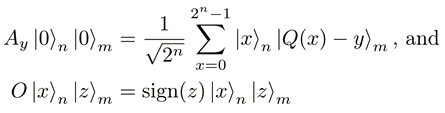

where $|x\rangle$ is the binary encoding of the integer $x$. 

At each iteration in which the threshold $y$ is updated, we adapt $A_y$ such that the function values are shifted up or down (for minimum and maxmimum respectively) by $y$. For example, in the context of finding the minimum, as the value of $y$ decreases, the search space (negative values) also decreases, until only the minimum value remains. A concrete example will be explored in the next section.

## The Problem

The following is a toy example of a minimization problem.

\begin{eqnarray}
\min_{x \in \{0, 1\}^3} -2x_1x_3 - x_2x_3 - 1x_1 + 2x_2 - 3x_3.
\end{eqnarray}

For our initial steps, we create a docplex model that defines the problem above, and then use the ```from_docplex()``` function to convert the model to a ```QuadraticProgram```, which can be used to represent a QUBO in Qiskit Optimization.

## Loading a `Quadratic Program` from an LP file

In [7]:
from qiskit.aqua.algorithms import NumPyMinimumEigensolver
from qiskit.optimization.algorithms import GroverOptimizer, MinimumEigenOptimizer
from qiskit.optimization.problems import QuadraticProgram
from qiskit import BasicAer
from docplex.mp.model import Model

backend = BasicAer.get_backend('statevector_simulator')

Qiskit's optimization module supports the conversion from Docplex model. You can easily make a model of an optimization problem with Docplex.
You can find the documentation of Docplex at https://ibmdecisionoptimization.github.io/docplex-doc/mp/index.html

You can load a Docplex model to `QuadraticProgram` by invoking `from_docplex`.

## Loading a `QuadraticProgram` from a docplex model

In [8]:
# Make a Docplex model
from docplex.mp.model import Model

model = Model()
x0 = model.binary_var(name='x0')
x1 = model.binary_var(name='x1')
x2 = model.binary_var(name='x2')
model.minimize(-x0+2*x1-3*x2-2*x0*x2-1*x1*x2)
qp = QuadraticProgram()
qp.from_docplex(model)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model2

Minimize
 obj: - x0 + 2 x1 - 3 x2 + [ - 4 x0*x2 - 2 x1*x2 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1

Binaries
 x0 x1 x2
End



In [9]:
backend = BasicAer.get_backend('statevector_simulator')

Next, we create a `GroverOptimizer` that uses 6 qubits to encode the value, and will terminate after there have been 10 iterations of GAS without progress (i.e. the value of $y$ does not change). The `solve()` function takes the `QuadraticProgram` we created earlier, and returns a results object that contains information about the run.

In [10]:
grover_optimizer = GroverOptimizer(6, num_iterations=10, quantum_instance=backend)
results = grover_optimizer.solve(qp)
print("x={}".format(results.x))
print("fval={}".format(results.fval))

x=[1 0 1]
fval=-6.0


## Check that GroverOptimizer finds the correct value

We can verify that the algorithm is working correctly using the `MinimumEigenOptimizer` in Qiskit.

In [11]:
exact_solver = MinimumEigenOptimizer(NumPyMinimumEigensolver())
exact_result = exact_solver.solve(qp)
print("x={}".format(exact_result.x))
print("fval={}".format(exact_result.fval))

x=[1. 0. 1.]
fval=-6.0
